In [70]:
from time import time, time_ns
import numpy as np
import matplotlib.pyplot as plt

In [431]:
class LPscheme:
    def __init__(self, M=20, N=20, q=97):
        self.debug = False
        self.M = M
        self.N = N
        self.q = q
        
        # set random seed
        self.__s_A  = np.random.randint(0, 1000)
        self.__s_e  = np.random.randint(0, 1000)
        self.__s_s  = np.random.randint(0, 1000)
        self.__s_s1 = np.random.randint(0, 1000)
        self.__s_e1 = np.random.randint(0, 1000)
        self.__s_e2 = np.random.randint(0, 1000)
        
    def KeyGen(self):
        np.random.seed(self.__s_A)
        A = np.array([[np.random.randint(0, self.q) for _ in range(self.N)] for __ in range(self.M)])
        np.random.seed(self.__s_e)
        e = np.random.binomial(n=2, p=0.5, size=self.M)-1
        #e = [np.random.randint(2) for _ in range(self.M)]
        np.random.seed(self.__s_s)
        s = np.random.binomial(n=2, p=0.5, size=self.N)-1
        #s = [np.random.randint(2) for _ in range(self.N)]
        if np.all(s==0):
            np.random.seed(self.__s_s + self.__s_A)
            s = np.random.binomial(n=2, p=0.5, size=self.N)-1
        if self.debug:
            print("A = \n", A)
            print("error = \n", e)
            print("s = \n", s)
        # Public key b ---->
        b = (np.matmul(A, s) + e) % self.q
        return (A, b), s
    
    def encode(self, x): # x in {0, 1}
        return (self.q//2)*x

    def decode(self, c_v): # c_v is c-v
        return abs(int(round(c_v/(self.q//2))))
    
    def Enc(self, pk, m): # public key = (A,b)  message m in {0, 1}
        np.random.seed(self.__s_s1)
        s1 = np.random.binomial(n=2, p=0.5, size=self.M)-1
        #s1 = [np.random.randint(2) for _ in range(self.N)]
        np.random.seed(self.__s_e1)
        e1 = np.random.binomial(n=2, p=0.5, size=self.N)-1
        #e1 = [np.random.randint(2) for _ in range(self.N)]
        np.random.seed(self.__s_e2)
        e2 = np.random.binomial(n=2, p=0.5)-1
        #e2 = np.random.randint(2)
        
        A = pk[0]
        b = pk[1]
        b1 = (np.matmul(s1, A) + e1) % self.q

        # inner product <r, b>
        v1 = (np.inner(s1, b) + e2) % self.q
        c = (self.encode(m) + v1) % self.q

        if self.debug:
            print(s1, e1, e2)
            print("b1 = \n", b1)
            print("v1 = \n", v1)
        return (b1, c)
    
    def Dec(self, s, cipher): # s = secret key, cipher = (b1, c)
        b1 = cipher[0]
        c  = cipher[1]
        v = np.inner(b1, s) % self.q
        if self.debug:
            print(v)
        return self.decode(c-v)

In [432]:
n = 20
x = np.array(range(n))
y_enc = np.array([], dtype=int)
m = np.array([np.random.randint(0, 2) for _ in range(n+10)])
Cipher = []
PK = []
SK = []

for i in range(n+10):
    a = LPscheme(7, 4, 13)
    pk_a, sk_a = a.KeyGen()
    PK.append(pk_a)
    SK.append(sk_a)
    
    # record enc timing
    start = time_ns()
    cipher = a.Enc(pk_a, m[i])
    end = time_ns()
    
    #print("Key Generate time: %d" % (end-start))
    y_enc = np.append(y_enc, (end-start))
    Cipher.append(cipher)

print(m[10:])
"""
Cipher = Cipher[10:]
PK = PK[10:]
SK = SK[10:]
"""

#result = np.where(y == max(y))
#y = np.delete(y, result[0][0])
y_enc = y_enc[10:]
y_enc_ave = sum(y_enc)/len(y_enc)
print("Enc average: %f" % (y_enc_ave))
y_enc_ave = np.array([y_enc_ave for _ in range(n)])

[0 0 0 1 1 0 0 1 1 1 0 1 0 0 1 1 1 1 1 0]
Enc average: 24771.500000


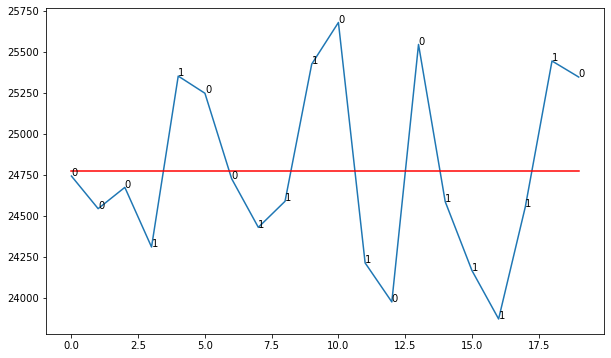

In [433]:
fig_enc, ax_enc = plt.subplots(1,1,figsize=(10,6))
ax_enc.plot(x, y_enc)
ax_enc.plot(x, y_enc_ave, 'r-')
for i, txt in enumerate(m[10:]):
    ax_enc.annotate(txt, (x[i], y_enc[i]))
plt.show()

In [434]:
Plain = []
y_dec = np.array([], dtype=int)

for i in range(n+10):
    start = time_ns()
    plain = Dec(SK[i], Cipher[i])
    end = time_ns()
    
    y_dec = np.append(y_dec, (end-start))
    Plain.append(plain)

y_dec = y_dec[10:]
y_dec_ave = sum(y_dec)/len(y_dec)
y_dec_ave = np.array([y_dec_ave for _ in range(n)])
print(Plain == m)
print(np.count_nonzero((Plain==m)==0))

[ True False False  True False  True False False  True False  True False
  True False False False  True False False False False False  True  True
 False False False False False  True]
20


[]

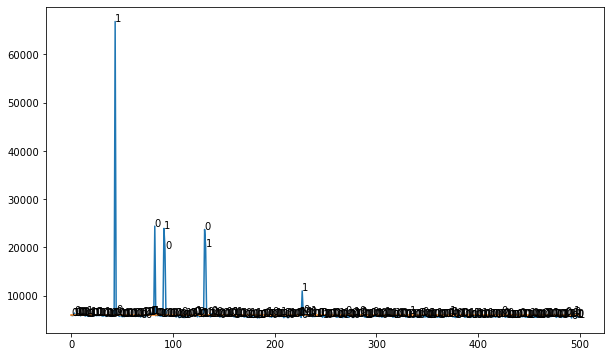

In [401]:
fig_dec, ax_dec = plt.subplots(1,1,figsize=(10,6))
ax_dec.plot(x, y_dec)
ax_dec.plot(x, y_dec_ave)
for i, txt in enumerate(Plain[10:]):
    ax_dec.annotate(txt, (x[i], y_dec[i]))
plt.plot()

In [402]:
from math import sqrt, prod
def vector_distance(vector):
    temp = 0
    for i in vector:
        temp += i*i
    temp = sqrt(temp)
    return temp

SK_pre = np.array([])
for i in SK[10:]:
    SK_pre = np.append(SK_pre, vector_distance(i))

In [390]:
"""
def matrix2d_distance(matrix): # 2D matrix
    temp = []
    for i in matrix:
        temp.append(vector_distance(i))
    return pow(prod(temp), 1/len(temp))

PK_pre = np.array([]) # store geometry mean of A
for i, j in PK[10:]:
    PK_pre = np.append(PK_pre, matrix2d_distance(i))
"""

'\ndef matrix2d_distance(matrix): # 2D matrix\n    temp = []\n    for i in matrix:\n        temp.append(vector_distance(i))\n    return pow(prod(temp), 1/len(temp))\n\nPK_pre = np.array([]) # store geometry mean of A\nfor i, j in PK[10:]:\n    PK_pre = np.append(PK_pre, matrix2d_distance(i))\n'

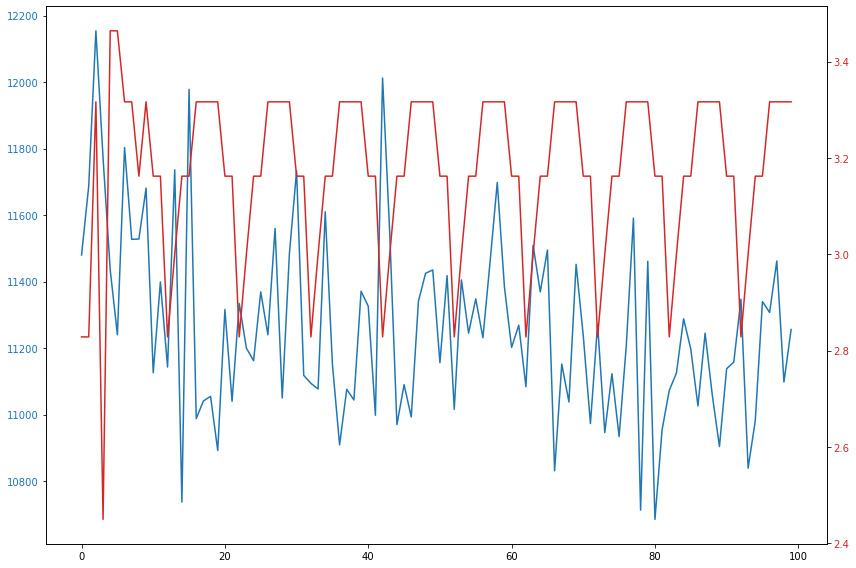

In [391]:
fig_dec, ax_dec = plt.subplots(1,1,figsize=(12,8))

color = 'tab:blue'
ax_dec.plot(x, y_dec, color=color)
ax_dec.tick_params(axis='y', labelcolor=color)

ax_SK = ax_dec.twinx()
color = 'tab:red'
ax_SK.plot(x, SK_pre, color=color)
ax_SK.tick_params(axis='y', labelcolor=color)

fig_dec.tight_layout()

"""
fig_enc, ax_enc = plt.subplots(1,1,figsize=(12,8))

color = 'tab:blue'
ax_enc.plot(x, y_enc, color=color)
ax_enc.tick_params(axis='y', labelcolor=color)

ax_PK = ax_enc.twinx()
color = 'tab:green'
ax_PK.plot(x, PK_pre, color=color)
ax_PK.tick_params(axis='y', labelcolor=color)

fig_enc.tight_layout()
"""
plt.show()

In [392]:
import scipy.stats
print(scipy.stats.pearsonr(y_dec, SK_pre)[0])

-0.10486234543716452
